In [19]:
import pywt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
import pickle
import plotly.express as px
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
import neurokit2 as nk
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 6)
plt.style.use('ggplot') # nicer plots
import os, re
from importlib import reload
import empatica_helpers as eh
import helpers as h

# eh.move_folders_to_root('input/empatica/')
# eh.rename_folders('input/empatica/')
# dir_list = h.get_dir_list('input/empatica/')

df = pd.read_csv('output/empatica_raw.csv')
ibi_df = pd.read_csv('output/empatica_ibi.csv')


In [91]:
print(df.isnull().sum())
print("---------------------------")
print(df.head())
print("---------------------------")
print(ibi_df.head())

acc_x          0
acc_y          0
acc_z          0
temp           0
eda            0
bvp            0
hr           576
datetime       0
unix_time      0
source         0
dtype: int64
---------------------------
   acc_x  acc_y  acc_z  temp  eda   bvp    hr                    datetime  \
0  15.00 -33.00 -55.00 24.29 0.02 17.77 52.00  2023-04-04 06:38:50.000000   
1   8.88 -29.52 -53.18 24.30 0.02 -0.42 51.31  2023-04-04 06:38:50.015625   
2  11.00 -29.00 -51.00 24.31 0.02 -9.45 50.66  2023-04-04 06:38:50.031250   
3  20.28 -33.89 -52.02 24.32 0.01 -9.99 50.06  2023-04-04 06:38:50.046875   
4  26.00 -38.00 -53.00 24.32 0.01 -6.08 49.51  2023-04-04 06:38:50.062500   

      unix_time  source  
0 1680590330.00  pp9-d2  
1 1680590330.02  pp9-d2  
2 1680590330.03  pp9-d2  
3 1680590330.05  pp9-d2  
4 1680590330.06  pp9-d2  
---------------------------
   ibi                    datetime     unix_time  source
0 1.12  2023-04-04 08:39:22.687500 1680590362.69  pp9-d2
1 0.88  2023-04-04 08:39:23.

In [20]:
df['datetime'] = pd.to_datetime(df['datetime']) # Convert datetime string to datetime object
ibi_df['datetime'] = pd.to_datetime(ibi_df['datetime']) # Convert datetime string to datetime object

# Create dataframe with ones for peaks 
peaks_df = pd.DataFrame({'datetime': ibi_df['datetime'], 'peaks': np.ones(len(ibi_df))})

# Sort df and peaks_df by 'datetime' (required by pd.merge_asof)
df.sort_values('datetime', inplace=True)
peaks_df.sort_values('datetime', inplace=True)

assert len(ibi_df) == len(peaks_df) # 76450

In [70]:
merged_df = pd.merge_asof(df, peaks_df, on='datetime', direction='forward', tolerance=pd.Timedelta('31.249ms'), allow_exact_matches=True) # 1000/64 * 0.75 = 11.718,75ms
# merged_df['peaks'] = merged_df['peaks'].fillna(0) # Replace NaNs with 0s

assert len(merged_df) == len(df)

In [71]:
merged_df['peaks'].value_counts()

peaks
1.00    65060
Name: count, dtype: int64

<Axes: >

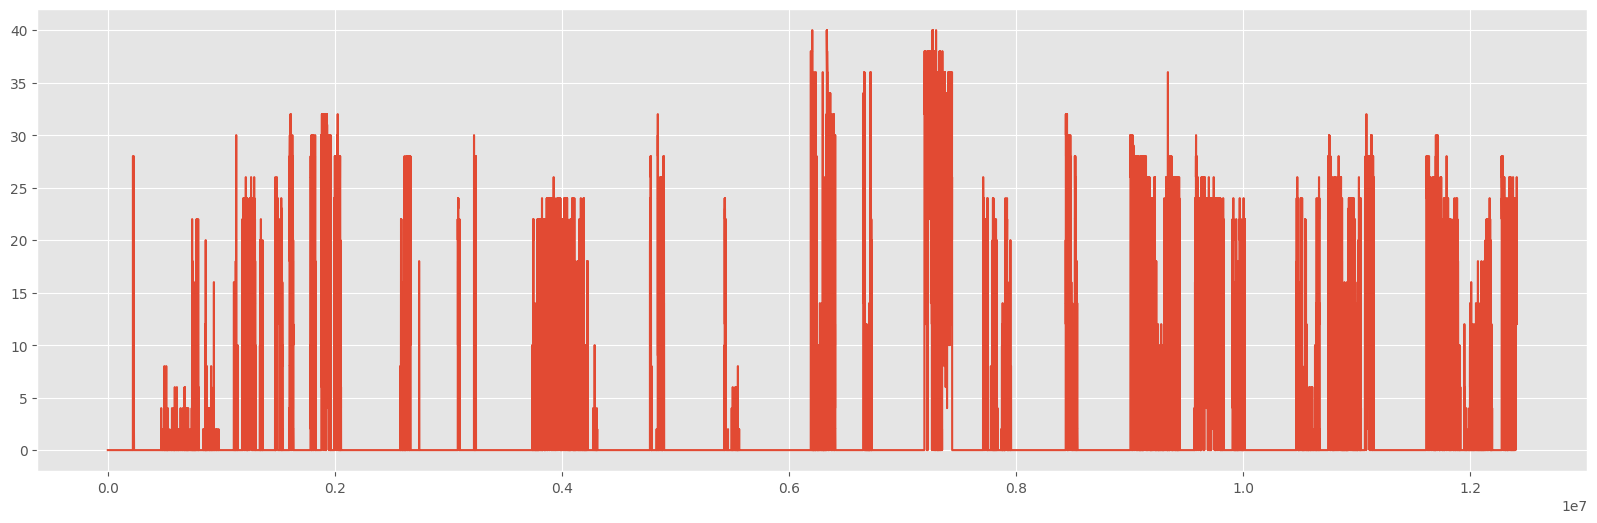

In [83]:
merged_df['peaks_per_10s'] = merged_df['peaks'].rolling(window=64*10).count()
merged_df['peaks_per_10s'].plot()

In [89]:

print(merged_df['peaks_per_10s'].value_counts()[0])
print(merged_df['peaks_per_10s'].value_counts()[0] / len(merged_df) * 100)

9345486
75.28678786792943


<Axes: xlabel='peaks_per_10s', ylabel='Count'>

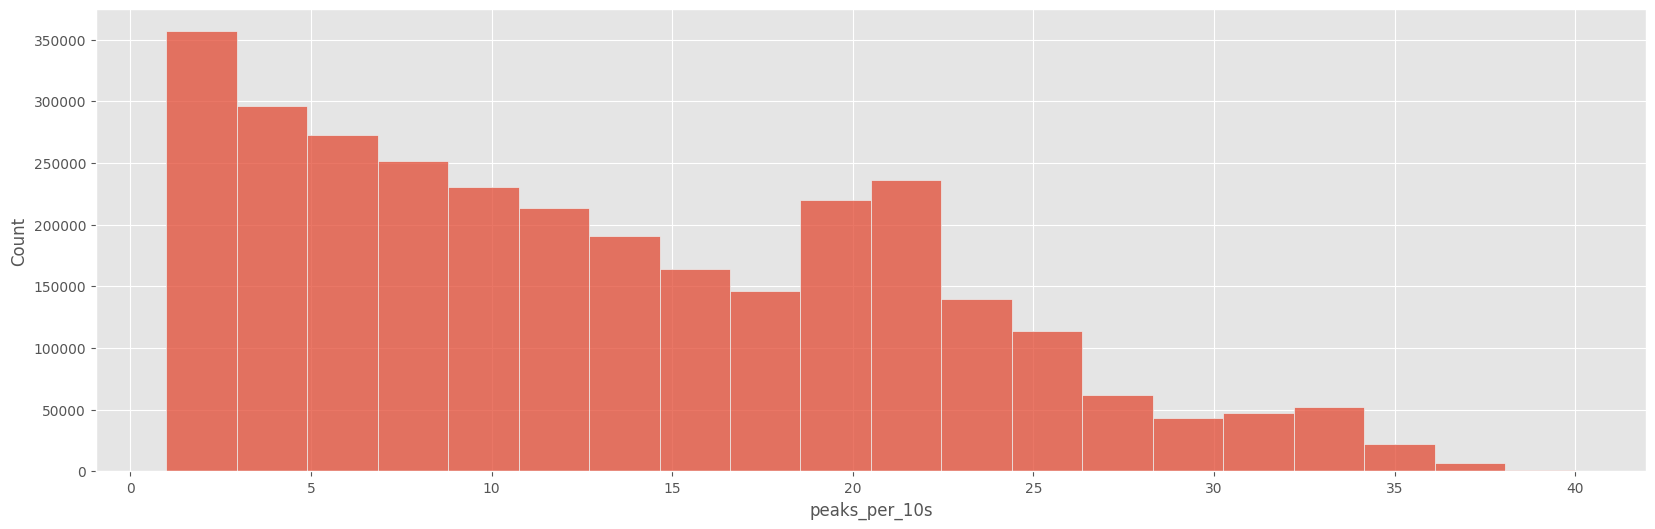

In [91]:
sns.histplot(merged_df[merged_df['peaks_per_10s'] > 0]['peaks_per_10s'], bins=20, kde=False)

In [93]:
merged_df.head()

# Save merged_df as "output/empatica_raw_with_peaks.csv"
merged_df.to_csv('output/empatica_raw_with_peaks.csv', index=False)